In [2]:
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
from edward.models import Normal
import seaborn as sns
plt.style.use('ggplot')
from edward.models import MultivariateNormalTriL
from edward.util import rbf

In [51]:
def build_toy_dataset(N, D):
    #D = len(w)
    x = np.random.normal(0.0, 1.0, size=(N, D))
    x = np.array(x, dtype='float32')
    ed.get_session()
    f = np.random.multivariate_normal(mean=np.zeros(N), cov= np.linalg.cholesky(rbf(x).eval()))
    y = np.random.normal(f, np.ones(N))
    return x, y


#ed.set_seed(55)

N = 40  # number of data points
D = 10  # number of features

#X_train, y_train = build_toy_dataset(N, D)
#X_test, y_test = build_toy_dataset(N, D)    
# These above 2 lines of code are wrong, they use different kernel function since X_trian and test are different, this is why predictive mean doesn't match test.
# need to use consistant kernel (seperate data as training and testing set)

x, y = build_toy_dataset(N, D)
X_train = x
y_train = y
X_test = x[20:40,:]
y_test = y[20:40]

In [39]:
X = tf.placeholder(tf.float32, [N, D])
f = MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X)))
#w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc= f + b, scale=tf.ones(N))

In [5]:
qf = Normal(loc=tf.get_variable("qf/loc", [N]), scale=tf.nn.softplus(tf.get_variable("qf/scale", [N])))
qb = Normal(loc=tf.get_variable("qb/loc", [1]), scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

In [40]:
inference = ed.KLqp({f: qf, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples = 5, n_iter=3000)

3000/3000 [100%] ██████████████████████████████ Elapsed: 13s | Loss: 74.357


In [56]:
y_post = Normal(loc = qf + qb , scale = tf.ones(N))

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:


TypeError: Key-value pair in data does not have same shape: (40,), (20,)

In [57]:
sess = ed.get_session()
np.mean([sess.run(y_post, feed_dict={X: X_test}) for _ in range(2000)]),  y_test.mean()

ValueError: Cannot feed value of shape (20, 10) for Tensor u'Placeholder_1:0', which has shape '(40, 10)'

In [45]:
# Predictions compared with test data(y_test)
samplers = np.array([sess.run(y_post, feed_dict={X: X_test}) for _ in range(2000)])
predict = np.arange(N)
predict = predict.astype(float)
for i in range(N):
    predict[i] = np.mean(samplers[:,i])

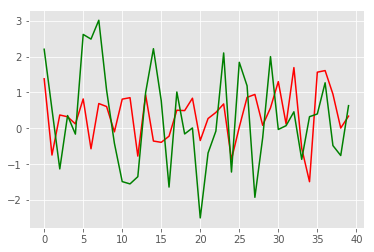

In [46]:
plt.plot(predict, color = 'red')
plt.plot(y_test, color = 'green')

In [52]:
# Numerical prediction check
x_train32 = np.array(X_train, dtype='float32')
x_test32 = np.array(X_test, dtype='float32')
K = np.linalg.cholesky(rbf(x_train32).eval())
K_noise = K + np.eye(N)*(1e-1)  # epsilon term to improve stability. thanks to Dustin: https://github.com/blei-lab/edward/blob/master/examples/cox_process.py
k_s = rbf(x_test32, x_train32).eval()

In [53]:
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
predict_mean = np.dot(k_s, alpha)

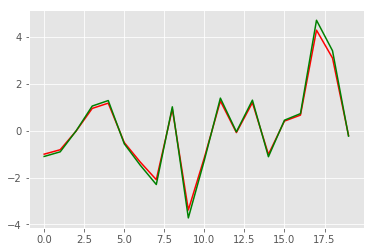

In [54]:
plt.plot(predict_mean, color = 'red')
plt.plot(y_test, color = 'green')

In [55]:
predict_mean, y_test

(array([ -9.97292858e-01,  -8.08141865e-01,  -3.11062838e-03,
          9.56175177e-01,   1.18116474e+00,  -5.00584465e-01,
         -1.33622828e+00,  -2.08587434e+00,   9.28388225e-01,
         -3.38094133e+00,  -1.14332121e+00,   1.27096990e+00,
         -7.57118499e-02,   1.20107205e+00,  -1.00710067e+00,
          4.14716266e-01,   6.70970923e-01,   4.29723452e+00,
          3.10695725e+00,  -1.97871462e-01]),
 array([ -1.09536144e+00,  -8.97675998e-01,   2.77637123e-03,
          1.05744644e+00,   1.29210133e+00,  -5.53851185e-01,
         -1.47034227e+00,  -2.29294843e+00,   1.02460908e+00,
         -3.71985286e+00,  -1.25470148e+00,   1.39599369e+00,
         -4.43766633e-02,   1.30910743e+00,  -1.10633831e+00,
          4.52941394e-01,   7.34212634e-01,   4.72171038e+00,
          3.41901870e+00,  -2.26342026e-01]))